In [1]:

from pydna.dseqrecord import Dseqrecord
from constrain.lab.PCR import primer_tm_neb
from pydna.design import primer_design
from pydna.dseqrecord import Dseqrecord
from  Bio.SeqRecord import SeqRecord
from pydna.dseqrecord import Dseqrecord
from typing import List

from typing import List

from Bio import SeqIO 
from pydna.dseqrecord import Dseqrecord
import pandas as pd
from constrain.lab.PCR import primer_tm_neb
from pydna.design import primer_design
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO 
from pydna.dseqrecord import Dseqrecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
import pandas as pd
from pydna.assembly import Assembly
from  Bio.SeqRecord import SeqRecord
from dna_features_viewer import GraphicFeature, CircularGraphicRecord
from dna_features_viewer import BiopythonTranslator
import os
from Bio import SeqIO 

from Bio.Seq import Seq


In [2]:
def get_kozak_seqs(chromosome: SeqRecord, feature_type: str = 'CDS') -> List[str]:
    """
    Get Kozak sequences from the coding sequences (CDS) of a chromosome.

    Parameters
    ----------
    chromosome : str
        The chromosome from which to extract the Kozak sequences.
    feature_type : str, optional
        The type of genomic feature to extract the Kozak sequences from. Default is 'CDS'.

    Returns
    -------
    List[str]
        A list of Kozak sequences extracted from the coding sequences of the chromosome.

    Raises
    ------
    ValueError
        If the specified feature type is not found in the chromosome.

    Notes
    -----
    The Kozak sequence is a motif that occurs in the vicinity of the translation start site of eukaryotic genes.
    It consists of the sequence "gccRccAUGG", where R is a purine and the AUG start codon is in bold.
    This function extracts the Kozak sequence from the coding sequences of a chromosome, given the feature type.

    Examples
    --------
    >>> chromosome = "ATCGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGC"
    >>> get_kozak_seqs(chromosome)
    []

    >>> chromosome = SeqIO.read("myseqs.fasta", "fasta")
    >>> get_kozak_seqs(chromosome, feature_type='CDS')
    ["gccaccATGG", "gccgccATGG"]
    """

    kozak_seqs = []
    for feature in chromosome.features:
        if feature.type == feature_type:
            if feature.strand == 1:
                start_location = feature.location.start
                kozak = chromosome[start_location-6 : start_location+3]
                kozak_seqs.append(Dseqrecord(kozak, name=f"Kozak_{feature.qualifiers['locus_tag'][0]}"))
                
            elif feature.strand == -1:
                start_location = feature.location.end
                kozak = chromosome[start_location -3: start_location+6]
                kozak_seqs.append(Dseqrecord(kozak.reverse_complement(), 
                                             name=f"Kozak_{feature.qualifiers['locus_tag'][0]}"))
                
    return kozak_seqs


# Aspergillus oryzae - kozak sequences

In [3]:
import os
dir_path = '../data/Aspergillus oryzae RIB40 (ascomycete fungi)/ncbi/'

# list file and directories
res = os.listdir(dir_path)
res

['chrom8.gb',
 'chrom3.gb',
 'chrom7.gb',
 'chrom6.gb',
 'chrom2.gb',
 'chrom5.gb',
 'chrom1.gb',
 'chrom4.gb',
 '.ipynb_checkpoints']

In [4]:
chromosomes = []
for name in res: 
    if name.endswith('.gb'): 
        seq = SeqIO.read(f'../data/Aspergillus oryzae RIB40 (ascomycete fungi)/ncbi/{name}', format = 'gb')
        chromosomes.append(seq)

In [5]:
print(chromosomes[0].seq[:1000])

TGACCCTAATGTTGACCCTAATGTTGACCCTAATTATTTATTTAACAGTGAAATCTGGCCAGAAACAGGACACAGTTGTCAGTGGCCCAGCAAGTGTTGAGAAGCACTGGTCTACTCTTGATTGGATCTGAATTTGGGCTTTTCTGCTCTACTCTGTAGAGTAGAAGACCTGTGAGGTGGCTCACGCTTGGAGAACACAAAACATAGACATGTTCTTGGTTTTGCATTTGTCAGCTCGATTCTCAGTATATAGTTACGAACGTGGCTATTTATAATTGAAAGAATAATATTTCAGACTAGACAGGTAAAGTGCAGGTATCTTATCTGATGAAGTAGGAAGCTAAGTTATCAAGTATGCTGTAAGTGAGGTTTAACATTAGATGTAAGTGTGCGGTACGTCCAGTCCTAAGCATAGTCCTCATTTAATAGCGGTTGGCTCAGTAGAATATATGTGCTAAGCTCTTGGTAGTGGGGCTGGGCATCAATTAACATATGTTTAATGGTCAAACCGAGTCCGACAAGGACTGTACTAAAAGGAAAAACTAATCATTATATGTTTGTGGGTCAGACCGATTTTAAGAATAACTGTAAAAATCCACCGCCGGGCACCGTTTTTGCAACATAGTGTAAGAGTTGGACGACCCCCTAGAAAGACTGAGGACTGTACGCGAAGGTAGCCCTCCGGACTGTACTGGTTGGAAGGGATGTTGTTGGAACAAGTTGTTGTTATTGGGCAAAATGCCTTTAGGCCGCCCCCTTACGGGACGGGCCGAAACATGAACCCCTGAACCTCCCGACGGCAACGAACGCGAAGAATCACCACCACGCGTCAGACCGAAATGCATTATCAGGCCCCCAAACAGCTACGCGCGCGAGCAAGAAGAACAAATCGAAATCAACAATACACGTCCCCAGCGGGTAAAGAACCCCAGAGGCAGACCAAGAAACCAAAGCGACGCGCCAGCAGGTCGGGAGGCACCGACCCCTGAAGGCACCCCAA

In [6]:
%%time
kozaks_for_all_chromosomes = []
for chromosome in chromosomes: 
    kozaks_for_all_chromosomes.extend(get_kozak_seqs(chromosome))

CPU times: user 1min 17s, sys: 527 ms, total: 1min 18s
Wall time: 1min 18s


In [7]:
seq_instances = [Seq(str(seq.seq)) for seq in kozaks_for_all_chromosomes ]

In [8]:
seq_instances[:10]

[Seq('GAAGAGATG'),
 Seq('ACGACTATG'),
 Seq('CTAACCATG'),
 Seq('GGCGCCATG'),
 Seq('GGTTCTATG'),
 Seq('AATGTTATG'),
 Seq('CAAGTCATG'),
 Seq('TTGATCATG'),
 Seq('TTAATGATG'),
 Seq('TTGAACATG')]

In [9]:
from Bio import motifs

m = motifs.create(seq_instances, alphabet="ATCG")
m.consensus

Seq('GCCAACATG')

In [10]:
df = pd.DataFrame(m.counts)
df

,A,T,C,G
0,3094,3093,2699,3176
1,2834,3623,3921,1684
2,3035,1683,5840,1504
3,7605,835,950,2672
4,4199,2429,4144,1290
5,3798,1728,4426,2110
6,12062,0,0,0
7,0,12062,0,0
8,0,0,0,12062


In [11]:
# getting the prevalence of each AA on each position 
df_pwn = pd.DataFrame(m.pwm)
#df_pwn.to_csv('../data/02_all_signal_peptides/df_pwn_68_positions.csv', index_label=False )
df_pwn

,A,T,C,G
0,0.256508,0.256425,0.223761,0.263306
1,0.234953,0.300365,0.325070,0.139612
2,0.251617,0.139529,0.484165,0.124689
3,0.630492,0.069226,0.078760,0.221522
4,0.348118,0.201376,0.343558,0.106947
5,0.314873,0.143260,0.366937,0.174930
6,1.000000,0.000000,0.000000,0.000000
7,0.000000,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,1.000000


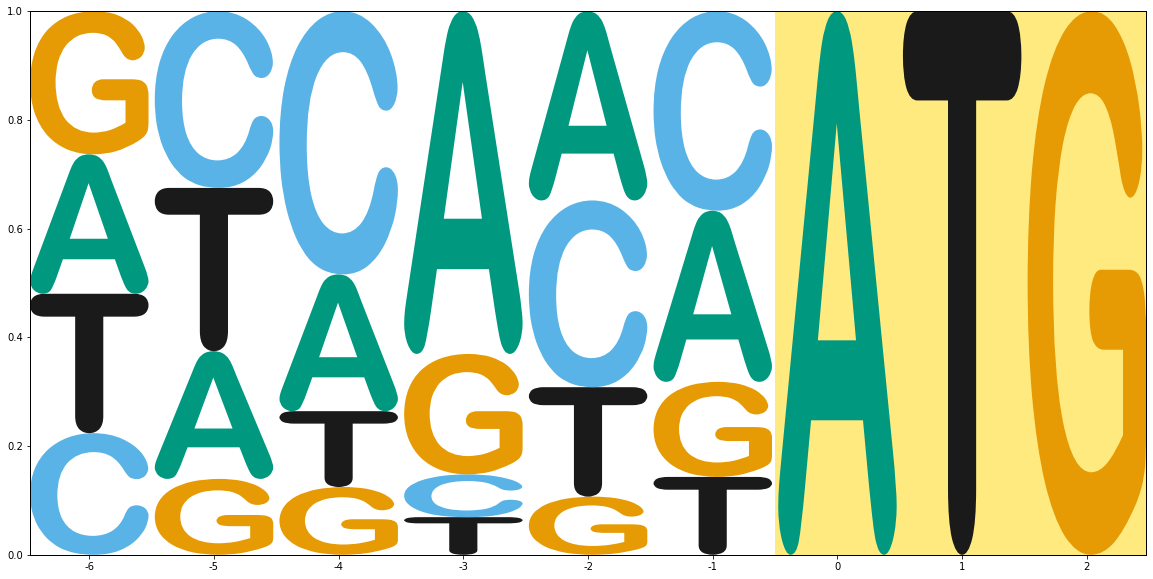

In [49]:
import logomaker as lm
import matplotlib.pyplot as plt


logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='colorblind_safe',
               figsize=(20,10),
               show_spines=True, 
               )


logo.style_xticks(anchor=0, spacing=1, rotation=0)

# TIS
logo.highlight_position(p=6, color='gold', alpha=.5)
logo.highlight_position(p=7, color='gold', alpha=.5)
logo.highlight_position(p=8, color='gold', alpha=.5)


logo.ax.set_xticklabels(['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2'])

plt.savefig('logo_a_oryzae.pdf')

In [15]:
type(logo)

logomaker.src.Logo.Logo

In [13]:
len(kozaks_for_all_chromosomes)

12062

# Aspergillus niger - kozak sequences